<a href="https://colab.research.google.com/github/Pilo1961/QuestionAnswer_System/blob/master/code/SentenceEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import json


# import stuff
%load_ext autoreload
%autoreload 2
%matplotlib inline

from random import randint
import numpy as np
import torch

## Leer dataset

In [2]:
#load data from google drive
from google.colab import drive
drive.mount('/content/drive')
path= "/content/drive/My Drive/QA/train-v1.0.json"
train=pd.read_json(path,orient='columns')
#path= "/content/drive/My Drive/data/QA/dev-v2.0.json"
#test=pd.read_json(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [73]:
# Lectura de datos
with open(path) as f: 
    d = json.load(f) 

df=pd.json_normalize(data=d['data'],
                        record_path=['paragraphs','qas','answers'],
                        record_prefix=None,
                        meta_prefix=None,
                        meta=['title',
                              ['paragraph','context'],
                              ['paragraph','qas','question'],
                              ['paragraph','qas','id']])

df.rename(columns={'paragraph.context':'context','paragraph.qas.question':'question','paragraph.qas.id':'id'},inplace=True)
df.head()

,answer_start,text,title,context,question,id
0,515,Saint Bernadette Soubirous,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182
1,187,a copper statue of Christ,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,5733be284776f4190066117f
2,279,the Main Building,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180
3,381,a Marian place of prayer and reflection,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,5733be284776f41900661181
4,92,a golden statue of the Virgin Mary,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,5733be284776f4190066117e


## Infersent 

Usamos el embedding preentrenado de InferSent. El modelo se entreno con GLoVE

In [4]:
#Importamos el pickle de infersent

#importa el modulo models de infersent
import sys
sys.path.append('/content/drive/My Drive/QA/')
from models import InferSent

model_version = 1
MODEL_PATH = "/content/drive/My Drive/QA/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [0]:
# Importa el embedding word2Vec GLovE preentrnado
W2V_PATH = '/content/drive/My Drive/QA/glove.840B.300d.txt' if model_version == 1 else 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

### Embedding de contextos

In [68]:
#tockeniza nuestros datos a oraciones
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize


contextos=df['context'].unique()
data=[]
for cont in contextos: # para cada contexto
  sample=cont
  for sent in sent_tokenize(sample): #Extrae las oraciones
    data.append(sent.lower())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# Load embeddings of K most frequent words
model.build_vocab(data,tokenize=True)

Found 67305(/97682) words with w2v vectors
Vocab size : 67305


In [8]:
# numero de oraciones
len(data)

93576

In [69]:
data[:5]

['architecturally, the school has a catholic character.',
 "atop the main building's gold dome is a golden statue of the virgin mary.",
 'immediately in front of the main building and facing it, is a copper statue of christ with arms upraised with the legend "venite ad me omnes".',
 'next to the main building is the basilica of the sacred heart.',
 'immediately behind the basilica is the grotto, a marian place of prayer and reflection.']

In [10]:
#hacemos el encoding
embeddings = model.encode(data, bsize=128, tokenize=False, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings)))

Nb words kept : 2067656/2391953 (86.4%)
Speed : 46.4 sentences/s (cpu mode, bsize=128)
nb sentences encoded : 93576


In [15]:
# dimensiones del embedding
embeddings.shape

(93576, 4096)

In [0]:
#diccionario con los embeddings
dict_context_embedding=dict(zip(data,embeddings))

### Embedding de preguntas

In [0]:
questions=list(df['question'])
q_tokens=[]
for q in questions: # para ca
  #qq=sent_tokenize(q) #Extrae las oraciones
  q_tokens.append(sent_tokenize(q.lower()))

In [58]:
q_tokens[:5]

[['to whom did the virgin mary allegedly appear in 1858 in lourdes france?'],
 ['what is in front of the notre dame main building?'],
 ['the basilica of the sacred heart at notre dame is beside to which structure?'],
 ['what is the grotto at notre dame?'],
 ['what sits on top of the main building at notre dame?']]

In [61]:
#hacemos el encoding
q_embeddings = model.encode(questions, bsize=128, tokenize=False, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings)))

Nb words kept : 774596/1056966 (73.3%)
Speed : 133.3 sentences/s (cpu mode, bsize=128)
nb sentences encoded : 93576


In [63]:
# dimensiones del embedding
q_embeddings.shape

(87636, 4096)

In [0]:
#diccionario con los embeddings
dict_context_embedding=dict(zip(questions,q_embeddings))

In [0]:
import pickle
with open("/content/drive/My Drive/QA/q-embedding.pickle", 'wb') as handle:
    pickle.dump(df, handle)

## Distancia entre oraciones

In [0]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [70]:
print("Distancias Coseno")
print("Pregunta:")
print(questions[0])
for i in range(10):
  print(i)
  print(data[i])
  print(cosine(embeddings[i], q_embeddings[0]))

Pregunta:
To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
0
architecturally, the school has a catholic character.
0.42867315
1
atop the main building's gold dome is a golden statue of the virgin mary.
0.40060252
2
immediately in front of the main building and facing it, is a copper statue of christ with arms upraised with the legend "venite ad me omnes".
0.5044748
3
next to the main building is the basilica of the sacred heart.
0.4586997
4
immediately behind the basilica is the grotto, a marian place of prayer and reflection.
0.5000678
5
it is a replica of the grotto at lourdes, france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858.
0.55071664
6
at the end of the main drive (and in a direct line that connects through 3 statues and the gold dome), is a simple, modern stone statue of mary.
0.48509812
7
as at most other universities, notre dame's students run a number of news media outlets.
0.46616355
8
the nine student-run outlets i

### Visualizacion de vector

Importancia de palabras dentro de la oracion.

In [75]:
df['context'][0]

'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.'

In [76]:
df['question'][0]

'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?'

In [78]:
df['text'][0]

'Saint Bernadette Soubirous'

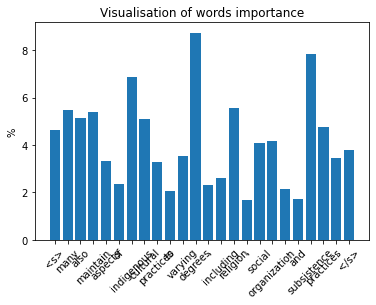

In [81]:

idx = randint(1, len(data))
_, _ = model.visualize(data[idx])

